In [126]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize

In [127]:
TRADING_DAYS_PER_YEAR = 252
RISK_FREE_RATE = 0.0619
np.random.seed(41)

[*********************100%%**********************]  11 of 11 completed


<Figure size 1500x3000 with 0 Axes>

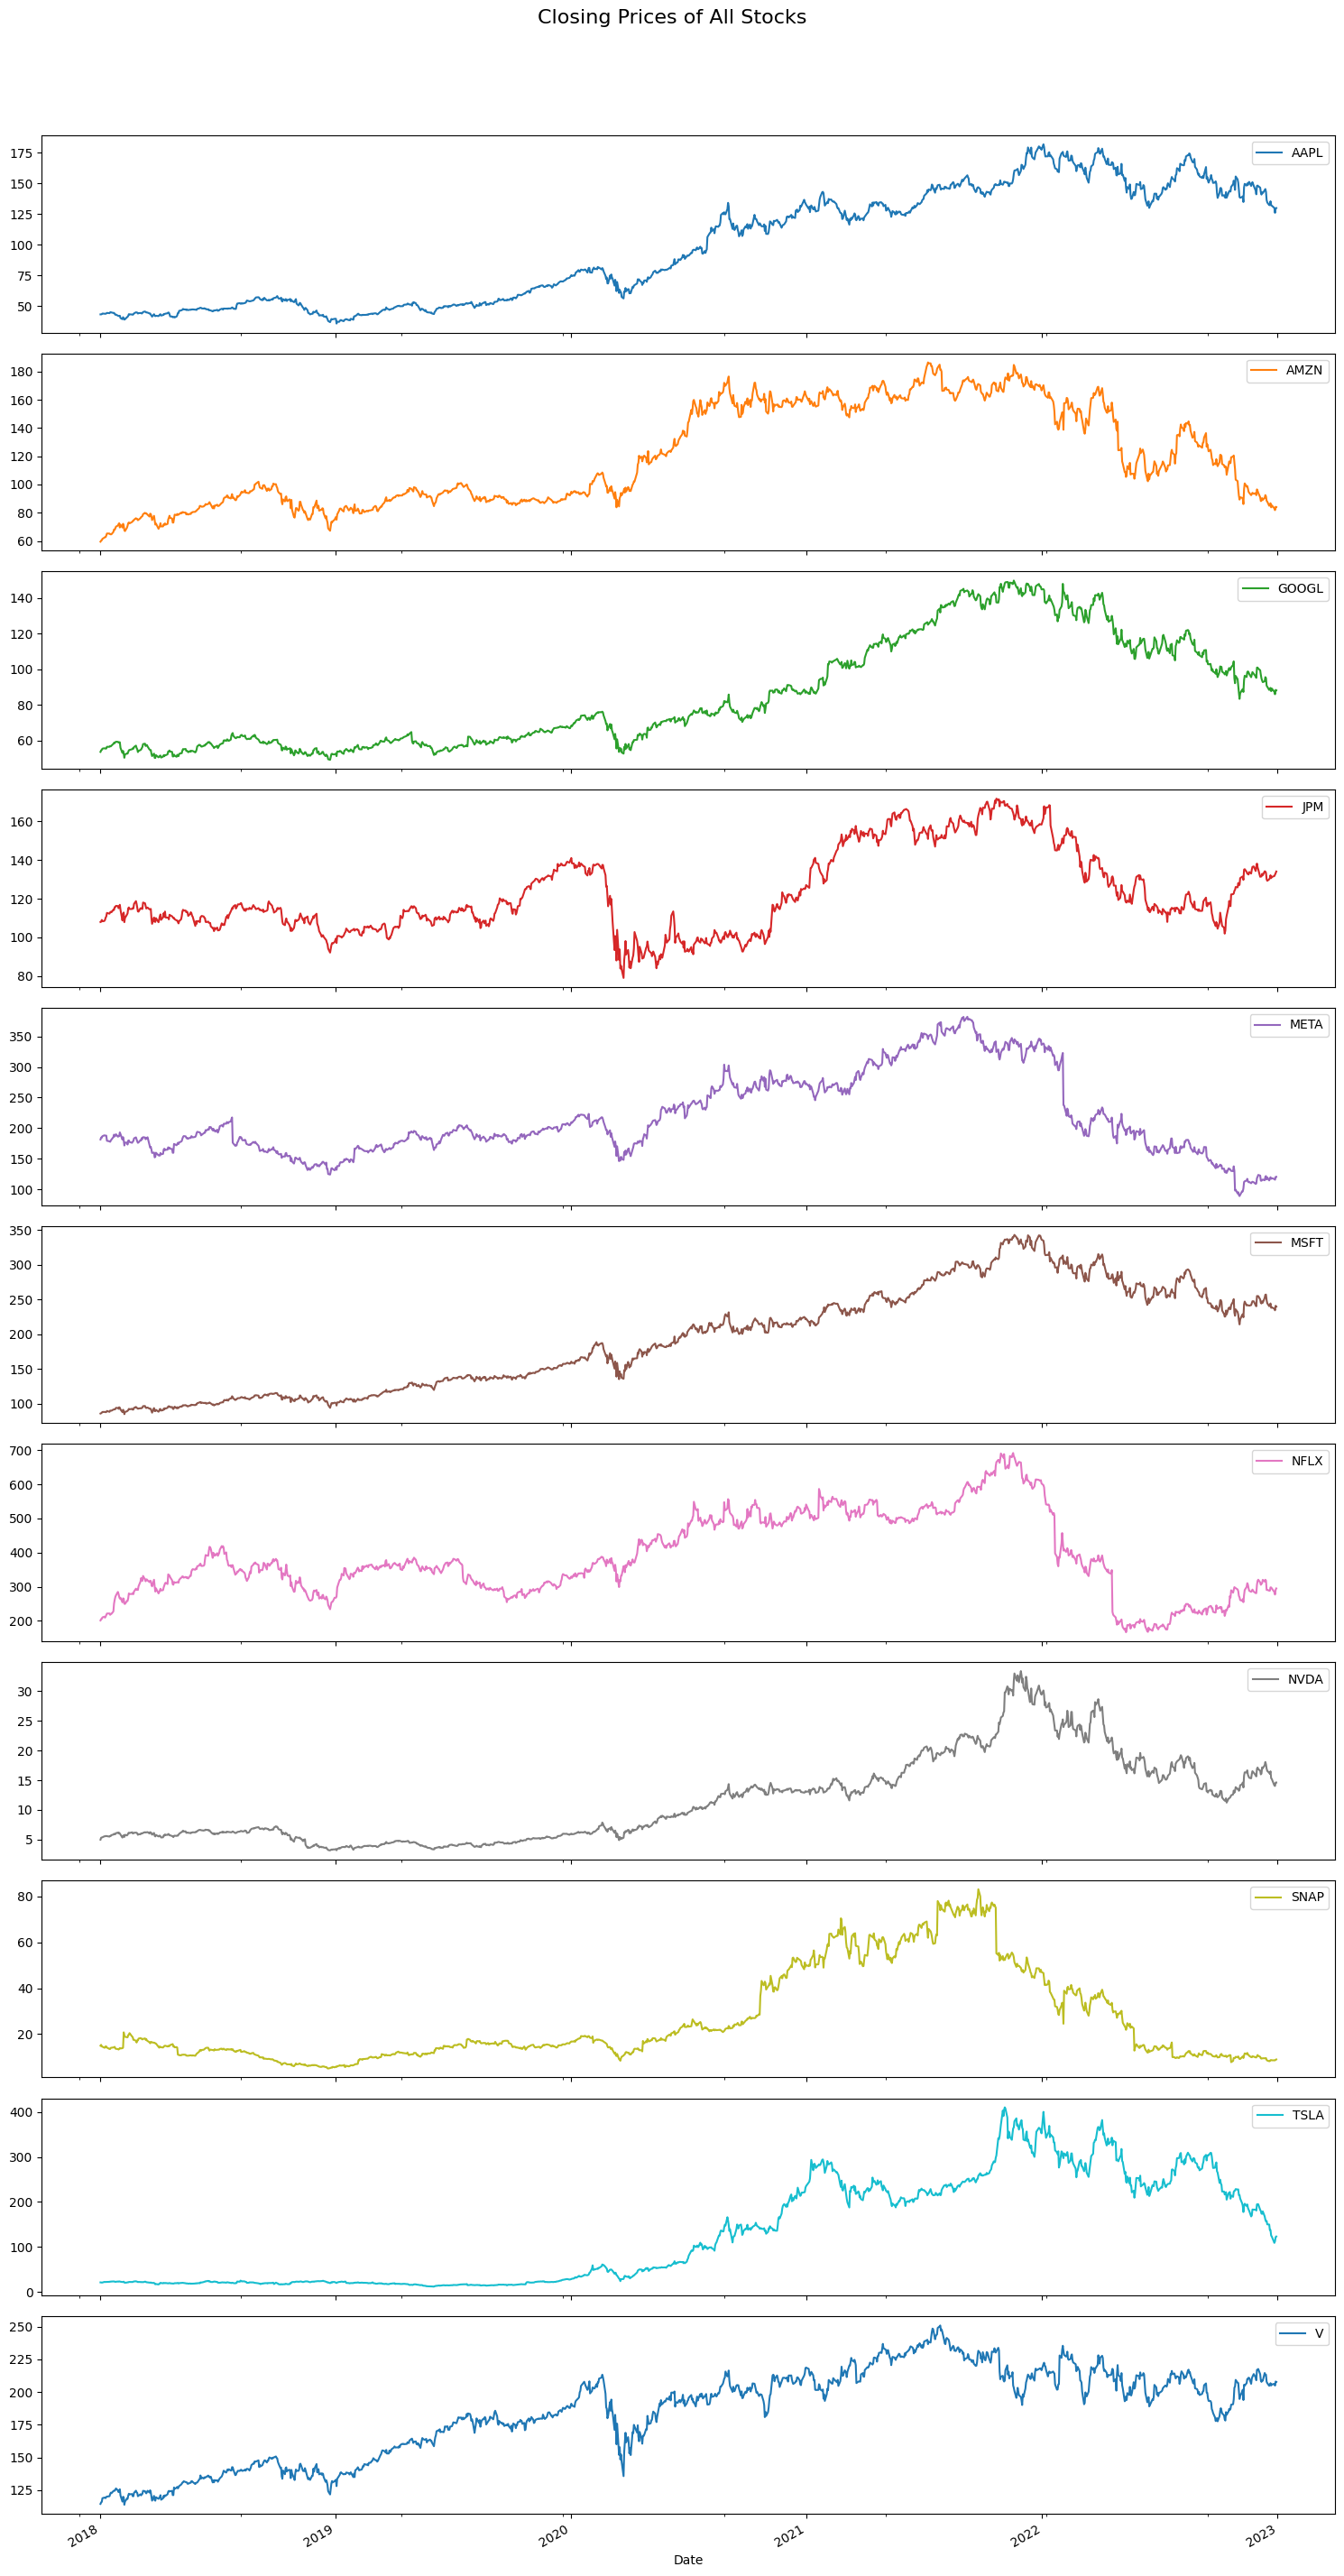

In [128]:
def load_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    closing_prices = data["Close"]
    return closing_prices

tickers = list(set(["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "NFLX", "JPM", "V","SNAP"]))
closing_prices = load_data(tickers, "2018-01-01", "2022-12-31")

def plot_closing_prices(closing_prices):
    plt.figure(figsize=(15, 30))
    closing_prices.plot(subplots=True, figsize=(15, 30))
    plt.suptitle("Closing Prices of All Stocks", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_closing_prices(closing_prices)

In [129]:
def calculate_daily_returns(closing_prices):
    return closing_prices.pct_change().dropna()

daily_returns = calculate_daily_returns(closing_prices)

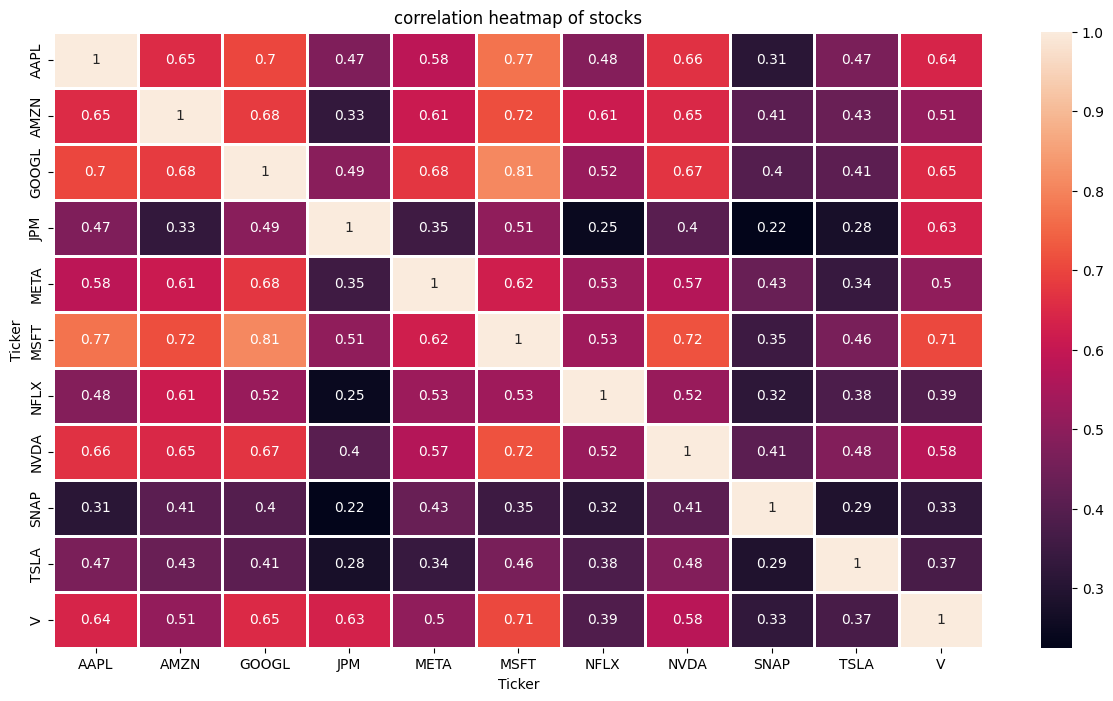

In [130]:
plt.figure(figsize=(15,8))
sns.heatmap(daily_returns.corr(),linecolor='white',linewidths=1,annot=True)
plt.title("correlation heatmap of stocks")
plt.show()

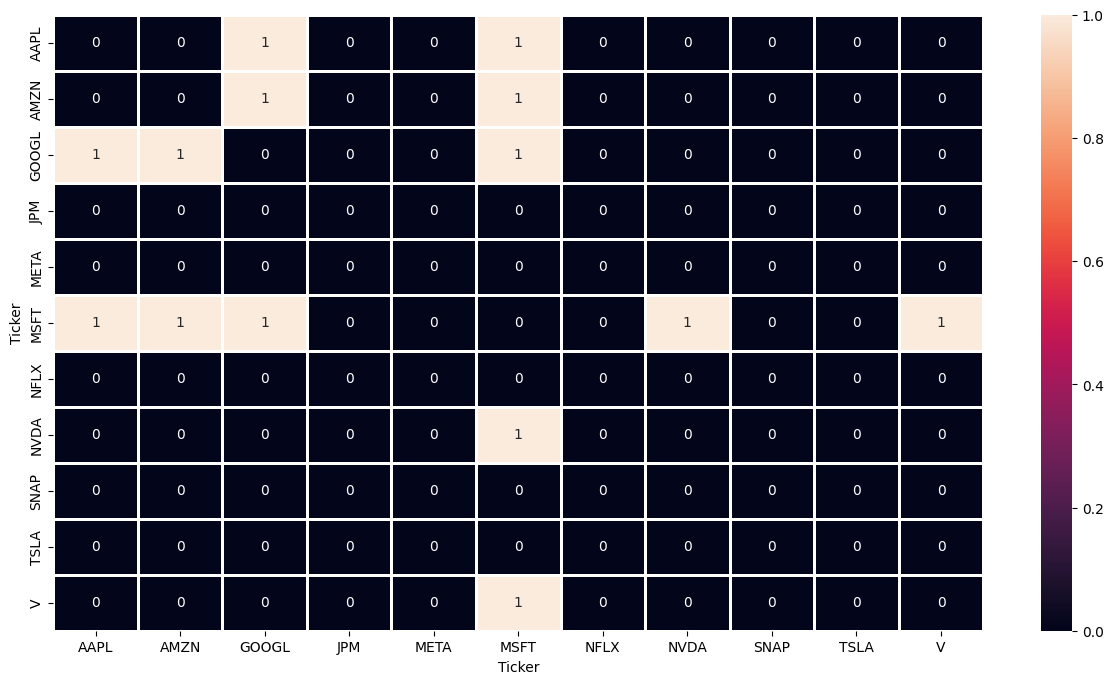

In [131]:
plt.figure(figsize=(15,8))
c = daily_returns.corr()
sns.heatmap(((c > 0.68) | (c < -0.68)) & (c != 1),linecolor='white',linewidths=1,annot = True)
plt.show()

c:\Users\zakbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\zakbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\zakbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\zakbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\zakbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been as

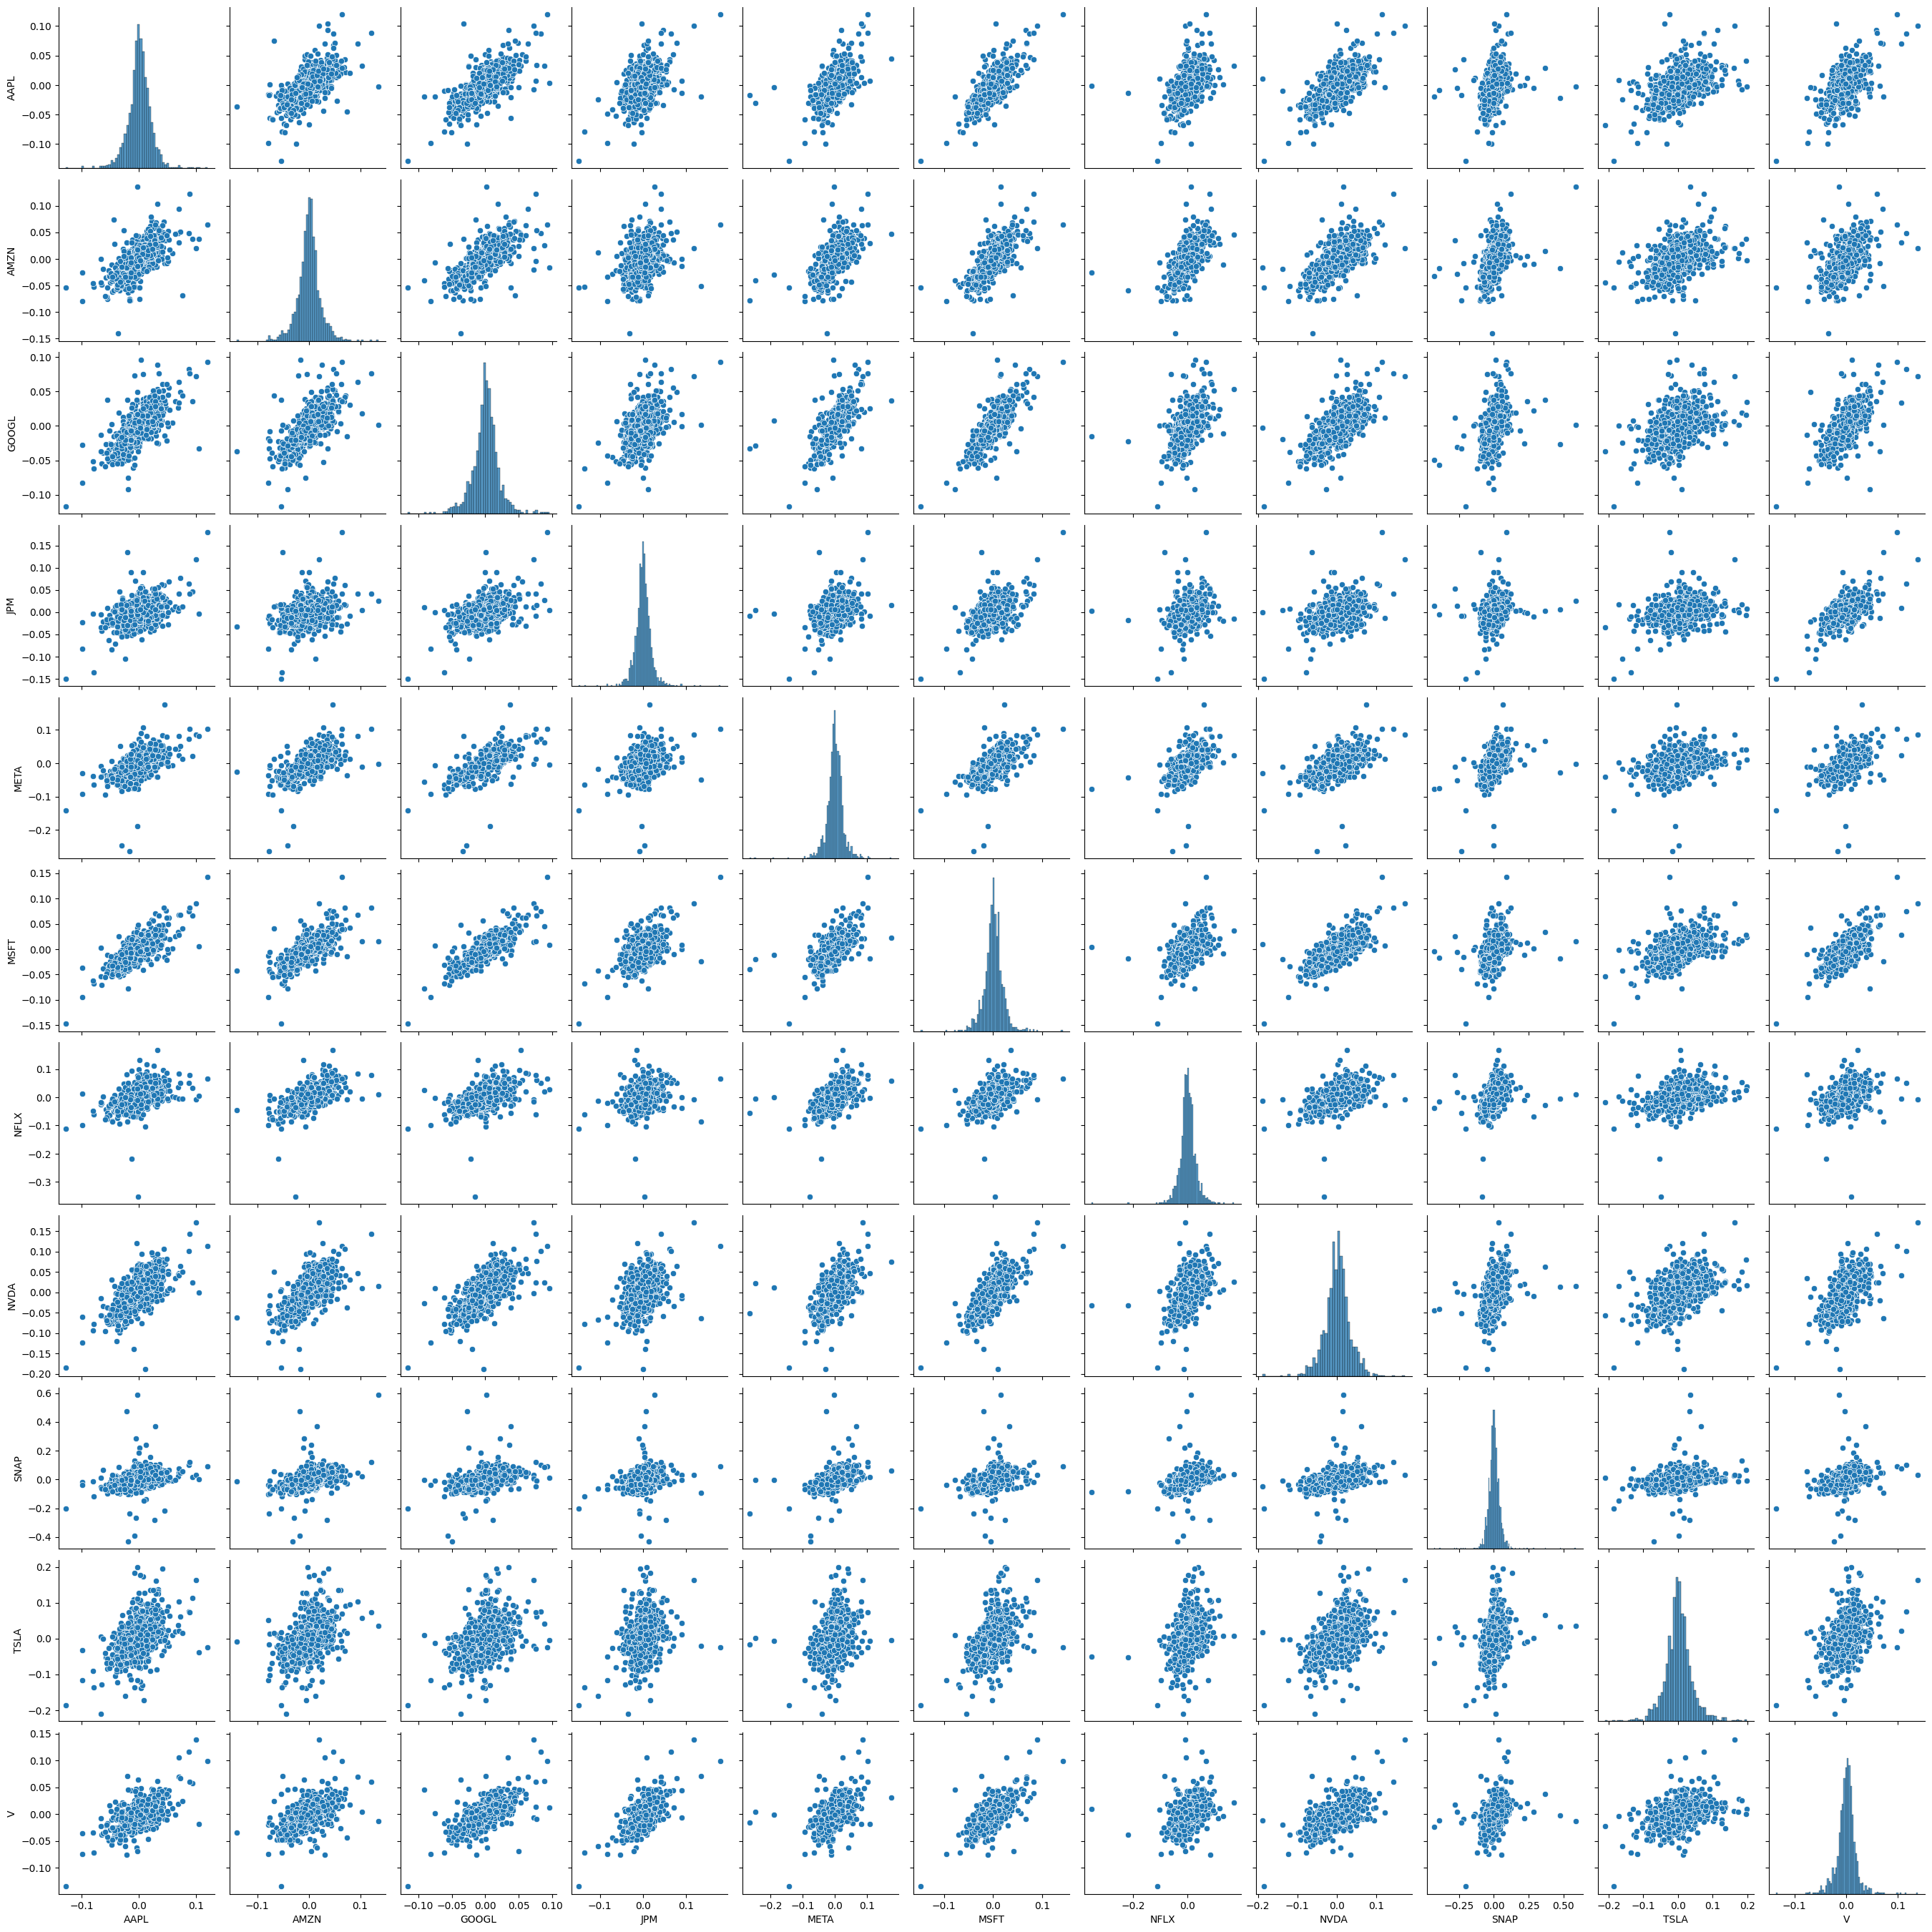

In [132]:
sns.pairplot(daily_returns,palette='coolwarm')
plt.show()

In [133]:
def calculate_annualized_returns(daily_returns):
    return (1+daily_returns.mean())**TRADING_DAYS_PER_YEAR - 1

def calculate_annualized_covariance(daily_returns):
    return daily_returns.cov()*TRADING_DAYS_PER_YEAR

annualized_returns = calculate_annualized_returns(daily_returns)
annualized_covariance = calculate_annualized_covariance(daily_returns)

In [134]:
annualized_returns

Ticker
AAPL     0.319492
AMZN     0.142585
GOOGL    0.160564
JPM      0.099518
META     0.014319
MSFT     0.288837
NFLX     0.214898
NVDA     0.420153
SNAP     0.237906
TSLA     0.758733
V        0.176419
dtype: float64

In [135]:
def generate_random_weights(num_assets):
    return np.random.dirichlet(np.ones(num_assets))

In [136]:
def calculate_portfolio_performance(weights,daily_returns):
    annualized_returns = calculate_annualized_returns(daily_returns)
    annualized_covariance = calculate_annualized_covariance(daily_returns)
    portfolio_return = np.sum(annualized_returns*weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(annualized_covariance, weights)))
    sharpe_ratio = (portfolio_return - RISK_FREE_RATE) / portfolio_risk
    return {'return': portfolio_return, 'risk': portfolio_risk, 'sharpe_ratio': sharpe_ratio}

In [137]:
def optimize_with_max_sharpe_ratio(daily_returns, num_assets):
    def negative_sharpe_ratio(weights):
        return (-1) * calculate_portfolio_performance(weights, daily_returns)['sharpe_ratio']

    result = minimize(
        negative_sharpe_ratio,
        generate_random_weights(num_assets),
        method='SLSQP',
        constraints=[{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.}],
        bounds=[(0., 1.) for _ in range(num_assets)]
    )
    return result

In [138]:
optimize_with_max_sharpe_ratio(daily_returns, len(tickers))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1096205984449257
       x: [ 3.125e-01  0.000e+00  2.702e-16  3.665e-17  1.927e-16
            1.432e-01  1.009e-16  8.444e-03  3.158e-17  5.358e-01
            0.000e+00]
     nit: 9
     jac: [-1.403e-01  1.987e-01  9.573e-02  8.685e-02  4.872e-01
           -1.402e-01  8.623e-02 -1.394e-01  1.517e-01 -1.404e-01
           -1.158e-02]
    nfev: 109
    njev: 9

In [139]:
def optimize_min_risk(daily_returns, num_assets):
    def minimize_risk(weights):
        portfolio_stats = calculate_portfolio_performance(weights, daily_returns)
        return portfolio_stats['risk']

    result = minimize(
        minimize_risk,
        generate_random_weights(num_assets),
        method='SLSQP',
        constraints=[{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.}],
        bounds=[(0., 1.) for _ in range(num_assets)]
    )
    return result

In [140]:
optimize_min_risk(daily_returns, len(tickers))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.25848643481291367
       x: [ 5.812e-02  1.476e-01  1.440e-01  3.038e-01  0.000e+00
            3.158e-02  2.590e-02  0.000e+00  0.000e+00  0.000e+00
            2.890e-01]
     nit: 14
     jac: [ 2.585e-01  2.584e-01  2.584e-01  2.586e-01  2.745e-01
            2.584e-01  2.581e-01  3.605e-01  3.155e-01  3.002e-01
            2.585e-01]
    nfev: 168
    njev: 14

In [141]:
def optimize_for_given_return(target_return, daily_returns, num_assets):
    def minimize_risk(weights):
        portfolio_stats = calculate_portfolio_performance(weights, daily_returns)
        return portfolio_stats['risk']

    result = minimize(
        minimize_risk,
        generate_random_weights(num_assets),
        method='SLSQP',
        constraints=[{'type': 'eq', 'fun': lambda w: calculate_portfolio_performance(w, daily_returns)['return'] - target_return},
                     {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}],
        bounds=[(0., 1.) for _ in range(num_assets)]
    )
    return result

In [142]:
optimize_for_given_return(0.25, daily_returns, len(tickers))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2697657068957943
       x: [ 1.881e-01  7.892e-03  6.524e-03  2.113e-01  1.476e-17
            2.567e-01  2.888e-02  0.000e+00  0.000e+00  5.723e-02
            2.435e-01]
     nit: 9
     jac: [ 2.853e-01  2.468e-01  2.504e-01  2.368e-01  2.718e-01
            2.781e-01  2.624e-01  3.778e-01  3.046e-01  3.798e-01
            2.540e-01]
    nfev: 108
    njev: 9

In [143]:
def monte_carlo_simulation(iterations, daily_returns, num_assets):
    portfolio_returns = []
    portfolio_risks = []
    portfolio_sharpe_ratios = []
    for _ in range(iterations):
        weights = generate_random_weights(num_assets)
        portfolio_stats = calculate_portfolio_performance(weights, daily_returns)
        portfolio_returns.append(portfolio_stats['return'])
        portfolio_risks.append(portfolio_stats['risk'])
        portfolio_sharpe_ratios.append(portfolio_stats['sharpe_ratio'])

    return np.array(portfolio_returns), np.array(portfolio_risks), np.array(portfolio_sharpe_ratios)

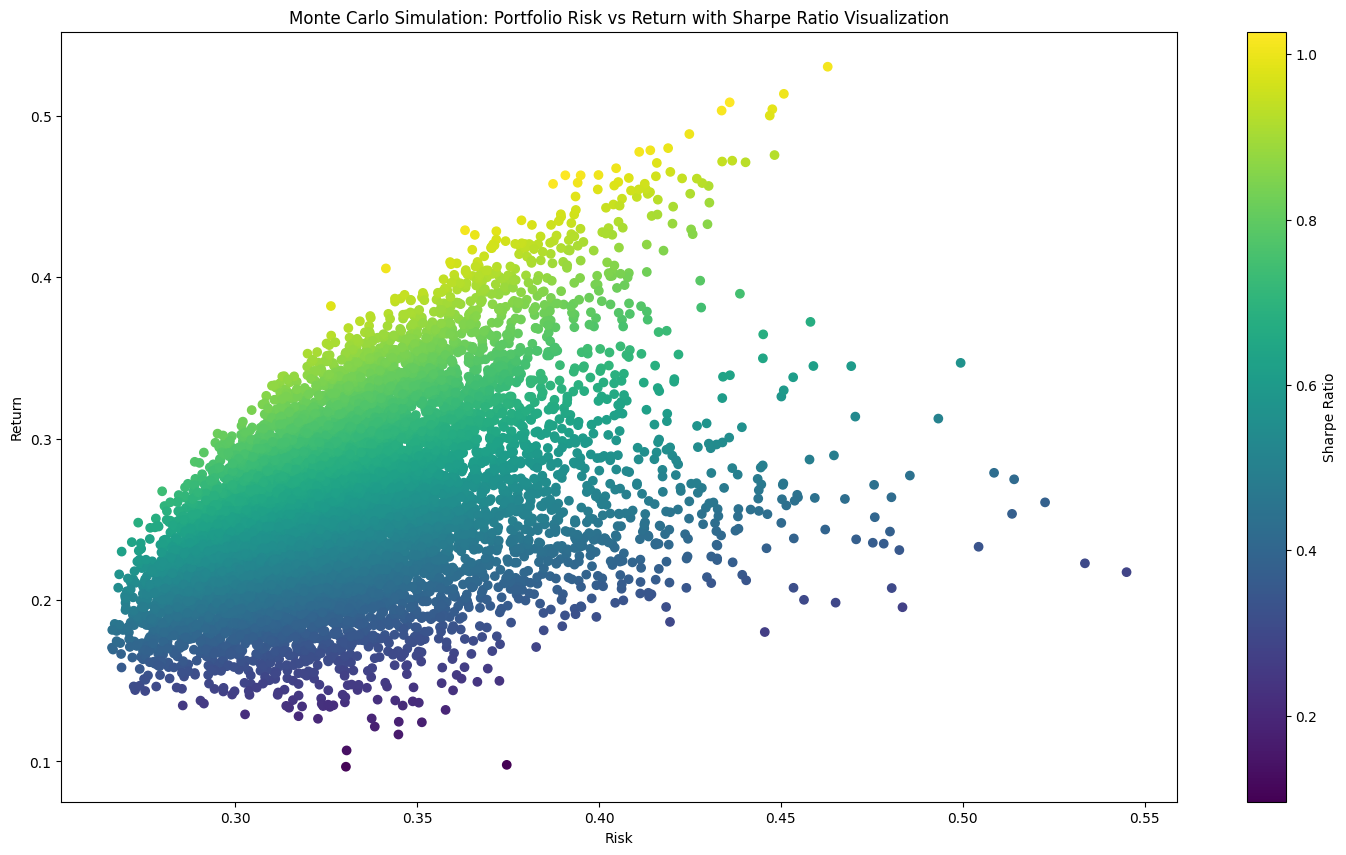

In [144]:
portfolio_returns, portfolio_risks, portfolio_sharpe_ratios = monte_carlo_simulation(10000, daily_returns, len(tickers))

plt.figure(figsize=(18, 10))
plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.title('Monte Carlo Simulation: Portfolio Risk vs Return with Sharpe Ratio Visualization')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()

In [145]:
def efficient_frontier(daily_returns, num_assets, returns_range):
    efficient_portfolios = []
    for target_return in returns_range:
        result = optimize_for_given_return(target_return, daily_returns, num_assets)
        weights = result.x
        portfolio_stats = calculate_portfolio_performance(weights, daily_returns)
        efficient_portfolios.append((portfolio_stats['return'], portfolio_stats['risk']))

    return np.array(efficient_portfolios)

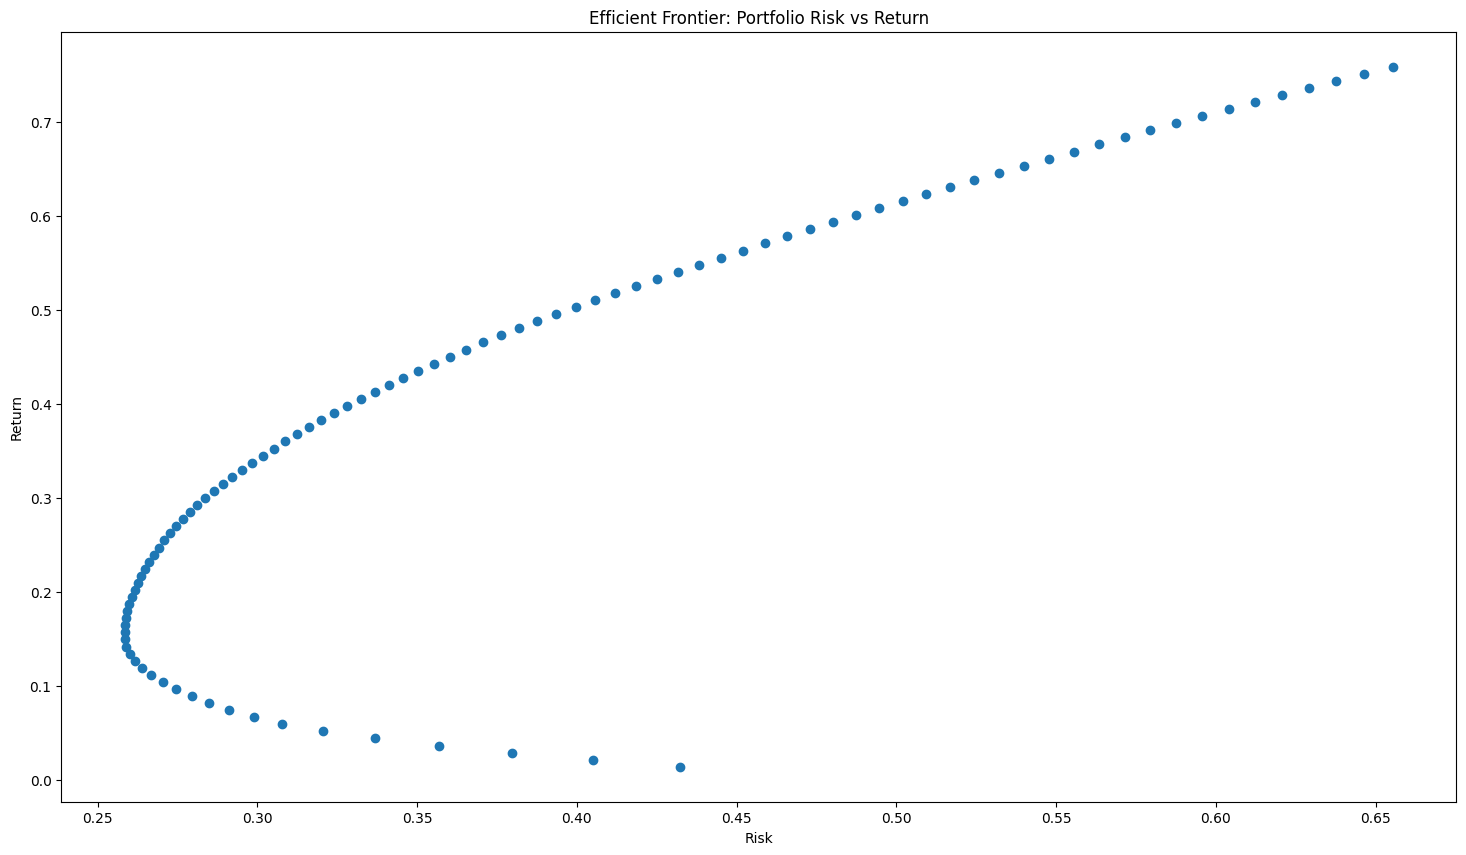

In [146]:
# Generate a range of target returns
returns_range = np.linspace(min(annualized_returns), max(annualized_returns), 100)

# Get efficient portfolios
efficient_portfolios = efficient_frontier(daily_returns, len(tickers), returns_range)

# Plot Efficient Frontier
plt.figure(figsize=(18, 10))
plt.scatter(efficient_portfolios[:, 1], efficient_portfolios[:, 0])
plt.title('Efficient Frontier: Portfolio Risk vs Return')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()

In [147]:
target_returns = np.linspace(portfolio_returns.min(), portfolio_returns.max(),70)

minimal_risks = []
for target_return in target_returns:
    optimal = optimize_for_given_return(target_return, daily_returns, len(tickers))
    minimal_risks.append(optimal['fun'])

minimal_risks = np.array(minimal_risks)
print(minimal_risks)

[0.2748072  0.27124357 0.26810641 0.2654095  0.26316661 0.26139003
 0.26008369 0.25919298 0.25873991 0.25853748 0.25849022 0.25858195
 0.25881617 0.25919272 0.25970542 0.26030636 0.26098894 0.26175098
 0.26259275 0.26351146 0.26450788 0.2655809  0.26672911 0.26795271
 0.26925001 0.27061905 0.27207143 0.27363168 0.27529538 0.27706254
 0.27893087 0.28090135 0.28296551 0.28512816 0.28739466 0.2897631
 0.29222965 0.29478776 0.29744552 0.30018746 0.30302096 0.30594045
 0.30894458 0.31202595 0.31518962 0.31842611 0.3217372  0.32511997
 0.32857304 0.33209451 0.33569512 0.33937829 0.34314047 0.34697974
 0.35090026 0.35494095 0.35910768 0.36338731 0.36778461 0.37229253
 0.37690711 0.38163059 0.38644086 0.39135262 0.39635648 0.40144821
 0.40662774 0.4118841  0.41722176 0.4226352 ]


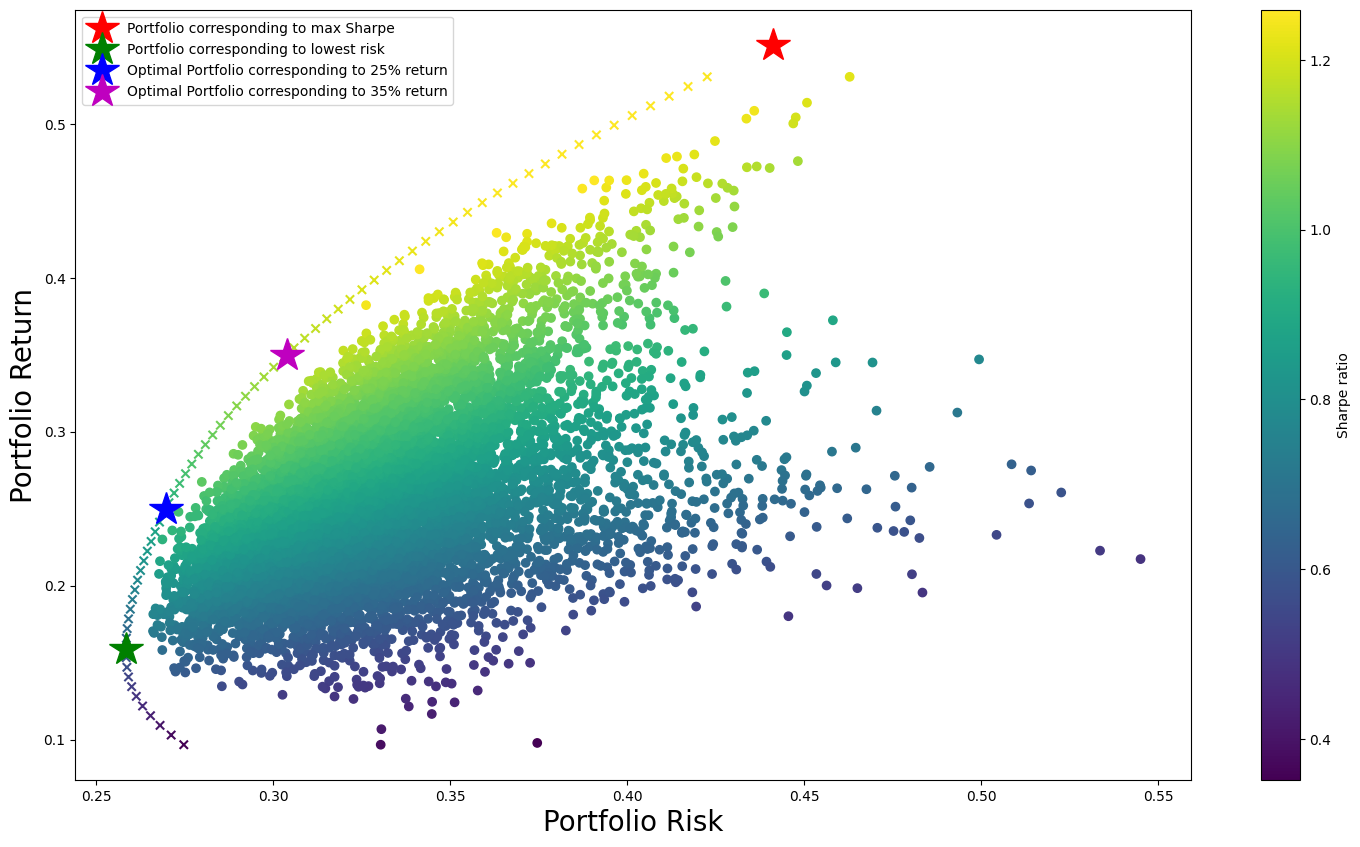

In [148]:
plt.figure(figsize=(18,10))

# Scatter plot of all portfolios
plt.scatter(portfolio_risks, portfolio_returns,
            c=(portfolio_returns / portfolio_risks), marker='o')

# Plotting the efficient frontier
plt.scatter(minimal_risks, target_returns,
            c=(target_returns / minimal_risks), marker='x')

# Portfolio with highest Sharpe Ratio
optimal_sr_weights = optimize_with_max_sharpe_ratio(daily_returns, len(tickers)).x
plt.plot(calculate_portfolio_performance(optimal_sr_weights, daily_returns)['risk'],
         calculate_portfolio_performance(optimal_sr_weights, daily_returns)['return'],
         'r*', markersize=25.0, label="Portfolio corresponding to max Sharpe")

# Optimal portfolio with lowest risk
optimal_min_risk_weights = optimize_min_risk(daily_returns, len(tickers)).x
plt.plot(calculate_portfolio_performance(optimal_min_risk_weights, daily_returns)['risk'],
         calculate_portfolio_performance(optimal_min_risk_weights, daily_returns)['return'],
         'g*', markersize=25.0, label="Portfolio corresponding to lowest risk")

# Optimal portfolio for 25% annual return
optimal_25_returns = optimize_for_given_return(0.25, daily_returns, len(tickers)).x
plt.plot(calculate_portfolio_performance(optimal_25_returns, daily_returns)['risk'],
         calculate_portfolio_performance(optimal_25_returns, daily_returns)['return'],
         'b*', markersize=25.0, label="Optimal Portfolio corresponding to 25% return")

# Optimal portfolio for 35% annual return
optimal_35_returns = optimize_for_given_return(0.35, daily_returns, len(tickers)).x
plt.plot(calculate_portfolio_performance(optimal_35_returns, daily_returns)['risk'],
         calculate_portfolio_performance(optimal_35_returns, daily_returns)['return'],
         'm*', markersize=25.0, label="Optimal Portfolio corresponding to 35% return")

plt.xlabel('Portfolio Risk', fontsize=20)
plt.ylabel('Portfolio Return', fontsize=20)
plt.legend(prop={'size': 10})
plt.colorbar(label='Sharpe ratio')
plt.show()